In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
import numpy as np
import torchvision
from BNN_MNIST import *
from spikingjelly.activation_based import functional
import numpy as np

60000 10000


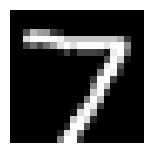

torch.Size([1, 20, 20])
torch.Size([1, 28, 28])
tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0],
         [  0,   0,  84, 185, 159, 151,  60,  36,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0],
         [  0,   0, 222, 254, 254, 254, 254, 241, 198, 198, 198, 198, 198, 198,
          198, 198, 170,  52,   0,   0],
         [  0,   0,  67, 114,  72, 114, 163, 227, 254, 225, 254, 254, 254, 250,
          229, 254, 254, 140,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,  17,  66,  14,  67,  67,  67,  59,
           21, 236, 254, 106,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           83, 253, 209, 

In [9]:
#加载MNIST数据集
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='D:\Python_code\IC2', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='D:\Python_code\IC2', train=False, transform=transform, download=True)
print(len(train_dataset),len(test_dataset))

#加载MNIST数据集的第一张图片
image, label = train_dataset[1]
#将图片用matplotlib画出来
import matplotlib.pyplot as plt
# 假设 train_dataset 是一个包含 (image, label) 的数据集
fig = plt.figure(figsize=(15, 5))  # 创建图像窗口并设置大小
# 绘制 10 张图像
crop_size=4
for i in range(1):
    image, label = test_dataset[-i]
    image_cropped = image[:, crop_size:-crop_size, crop_size:-crop_size]
    ax = plt.subplot(1, 10, i + 1)  # 创建 1 行 10 列的子图
    ax.imshow(image_cropped.squeeze().numpy(), cmap="gray")  # 绘制图像
    ax.axis("off")  # 隐藏坐标轴
plt.tight_layout()  # 自动调整布局
plt.show()  # 最后统一显示
print(image_cropped.shape)

#讲image转化为int8类型
image_cropped = image_cropped * 255
np.set_printoptions(linewidth=700)  # 设置行宽
print(image_cropped.int(),end=" ")
print(label)
#with open("image_cropped.txt", "w") as f:
    #for row in image_cropped:
     #   f.write(" ".join(map(str, row.tolist())) + "\n")

In [15]:
import os
import math
#按行将image转化为txt文件
'''
pad_zero_index=torch.zeros(9,8)
pad_zero_index[0,:]=torch.tensor([61,65,67,69,71,73,75,79])
pad_zero_index[1,:]=torch.tensor([101,105,107,109,111,113,115,119])
pad_zero_index[2,:]=torch.tensor([141,145,147,149,151,153,155,159])
pad_zero_index[3,:]=torch.tensor([181,185,187,189,191,193,195,199])
pad_zero_index[4,:]=torch.tensor([221,225,227,229,231,233,235,239])
pad_zero_index[5,:]=torch.tensor([261,265,267,269,271,273,275,279])
pad_zero_index[6,:]=torch.tensor([301,305,307,309,311,313,315,319])
pad_zero_index[7,:]=torch.tensor([341,345,347,349,351,353,355,359])
pad_zero_index[8,:]=torch.tensor([381,385,387,389,391,393,395,399])
#print(pad_zero_index)
base_dir_pre="D:\Python_code\IC2_python\image_matrix\image_test_pre"
base_dir="D:\Python_code\IC2_python\image_matrix\image_test"
base_dir_label="D:\Python_code\IC2_python\image_matrix\image_label"
for m in range(10000):
    image, label = test_dataset[m]
    image_cropped = image[:, crop_size:-crop_size, crop_size:-crop_size]*255
    image_cropped_int=image_cropped.int()
    image_test_pre_path=os.path.join(base_dir_pre, f"MNIST_images_{m}_pre.txt")
    image_test_path=os.path.join(base_dir, f"MNIST_images_{m}.txt")
    label_test_path=os.path.join(base_dir_label, f"MNIST_label_{m}.txt")
    with open(label_test_path, 'w') as f:
        f.write(f"{label}"+'\n')
    with open(image_test_pre_path, 'w') as f:
        for i in range(20):
            for j in range(20):
                flag=((i*20+((math.floor(j/4)+1)*4-j%4))==pad_zero_index).any()  #flag=1说明需要在后面补零
                flag=0
                f.write(format(image_cropped_int[0, i, (math.floor(j/2)+1)*2-j%2-1].item(), '08b') + (flag==1)*"")   #一行存四个数据  4 3 2 1 , 8 7 6 5 , 12 11 10 9
                #f.write(f"{(i*20+((math.floor(j/2)+1)*2-j%2)):0{8}d}"+(flag==1)*"000000")

    # 读取原始文件并重新组织内容
    input_file = image_test_pre_path  # 原始文件
    output_file = image_test_path  # 输出文件

    # 读取原始文件内容
    with open(input_file, "r") as infile:
        data = infile.read()  # 读取整个文件内容为字符串

    # 计算需要的行数
    line_length = 16  # 每行16个字符
    lines = [data[i:i + line_length] for i in range(0, len(data)+1, line_length)]

    # 将处理后的内容写入新文件
    with open(output_file, "w") as outfile:
        outfile.write("\n".join(lines))

    # 文件路径
    file_path = image_test_path

    # 要交换的两行索引（从 0 开始计数）
    line1_index = [17,19,21,23, 31,33,35,37, 45,47,49,51, 59,61,63,65, 73,75,77,79, 87,89,91,93, 101,103,105,107, 115,117,119,121, 129,131,133,135]
    line2_index=line1_index
    line1_index=[x - 1 for x in line1_index]


    # 读取文件内容
    with open(file_path, "r") as f:
        lines = f.readlines()  # 按行读取文件内容到列表

    for i in range(36):
        lines[line1_index[i]], lines[line2_index[i]] = lines[line2_index[i]], lines[line1_index[i]]
        # 写回文件
        with open(file_path, "w") as f:
            f.writelines(lines)
'''

'\n    # 文件路径\n    file_path = image_test_path\n\n    # 要交换的两行索引（从 0 开始计数）\n    line1_index = [17,19,21,23, 31,33,35,37, 45,47,49,51, 59,61,63,65, 73,75,77,79, 87,89,91,93, 101,103,105,107, 115,117,119,121, 129,131,133,135]\n    line2_index=line1_index\n    line1_index=[x - 1 for x in line1_index]\n\n\n    # 读取文件内容\n    with open(file_path, "r") as f:\n        lines = f.readlines()  # 按行读取文件内容到列表\n\n    for i in range(36):\n        lines[line1_index[i]], lines[line2_index[i]] = lines[line2_index[i]], lines[line1_index[i]]\n        # 写回文件\n        with open(file_path, "w") as f:\n            f.writelines(lines)\n'

In [4]:
def nbit_quantizer(tensor, n_bits_signed, min_val=None, max_val=None):
    """
    n-bit 量化器，将输入张量量化到指定比特范围。
    参数:
    - tensor: 待量化的输入张量 (PyTorch Tensor)
    - n_bits: 量化位数 (int)
    - min_val: 量化范围的最小值 (float, 可选，默认为 tensor.min())
    - max_val: 量化范围的最大值 (float, 可选，默认为 tensor.max())
    返回:
    - 量化后的张量 (PyTorch Tensor)
    """
    n_bits=n_bits_signed
    if n_bits < 1:
        raise ValueError("n_bits 必须大于或等于 1")

    # 自动计算量化范围
    min_val = tensor.min() if min_val is None else min_val
    max_val = tensor.max() if max_val is None else max_val

    # 防止范围错误
    if min_val >= max_val:
        raise ValueError("min_val 必须小于 max_val")

    # 量化级别数量
    levels = 2 ** n_bits-1  #-2^(n-1)+1~2^(n-1)-1

    # 量化步骤大小
    step = (max_val - min_val) / (levels-1)

    # 量化公式: 将值映射到离散区间
    quantized_pos = torch.round((tensor - min_val) / step) #量化到0-（2**n）-1
    quantized=(2/(levels-1))*quantized_pos-1 #量化到-1，1
    #quantized=torch.floor(tensor/4)
    return quantized

# 测试代码
if __name__ == "__main__":
    # 示例张量
    x = torch.tensor([[-0.1, 0.5, 0.9],
                      [1.2, 2.1, 2.5]])

    # 3-bit 量化
    quantized_x = nbit_quantizer(x, n_bits_signed=3)
    print("原始张量:")
    print(x)
    print("\n量化后的张量:")
    print(quantized_x)

原始张量:
tensor([[-0.1000,  0.5000,  0.9000],
        [ 1.2000,  2.1000,  2.5000]])

量化后的张量:
tensor([[-1.0000, -0.6667, -0.3333],
        [ 0.0000,  0.6667,  1.0000]])


In [5]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ch_in=6
        ch_out=10
        self.conv1 = BinaryConv2d(1,ch_in, kernel_size=4, stride=2, padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        #self.relu1 = nn.ReLU()
        #self.conv2 = BinaryConv2d(6, 12, kernel_size=5, stride=1, padding=0, bias=False)
        #self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.relu2 = nn.ReLU()
        self.fc1 = BinaryLinear(ch_in*4*4, 10, bias=False)
        #self.softmax=nn.Softmax(dim=1)
        #self.conv_ch = BinaryConv2d(ch_in,ch_out, kernel_size=4, stride=1, padding=0, bias=False)
        #self.conv_num = BinaryConv2d(ch_out,10, kernel_size=1, stride=1, padding=0, bias=False)
    def forward(self, x):
        #x=F.pad(x,(0,1,0,1))
        #x = x[:, crop_size+1:-crop_size, crop_size+1:-crop_size]
        x = self.conv1(x)
        #x = self.relu1(x)
        #x = nbit_quantizer(x, n_bits_signed=5)
        #x = self.relu1(x)
        #x=F.pad(x,(0,1,0,1))
        x = self.pool1(x)
        #x = nbit_quantizer(x, n_bits_signed=5)
        #x = x.view(x.size(0), -1)
        #x = self.conv_ch(x)
        #x = self.conv_num(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [6]:
net = LeNet()
print(net)
#将网络的权重初始化为-1
# for m in net.modules():
#     if isinstance(m, BinaryConv2d) or isinstance(m, BinaryLinear):
#         m.weight.data.fill_(1)
#加载权重
#net.load_state_dict(torch.load('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/train/weight/lenet_binary.pth'))
#将图片转化为网络的输入
'''print(image.shape)
image = image.unsqueeze(0)
image_cropped = image_cropped.unsqueeze(0)
output = net(image_cropped)
print(output.shape)
'''

LeNet(
  (conv1): BinaryConv2d(1, 6, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): BinaryLinear(in_features=96, out_features=10, bias=False)
)


'print(image.shape)\nimage = image.unsqueeze(0)\nimage_cropped = image_cropped.unsqueeze(0)\noutput = net(image_cropped)\nprint(output.shape)\n'

In [7]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [8]:
from tqdm import tqdm
np.int = int
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
criterion = nn.CrossEntropyLoss()
lambda_reg = 0.01
def loss_fn(output, target, weight, binary_weight):
    task_loss = criterion(output, target)
    quant_loss = sum(lambda_reg * torch.norm(w - bw, p=2) for w,bw in zip(weight,binary_weight))
    return task_loss + quant_loss

optimizer = optim.Adam(net.parameters(), lr=0.002)
EPOCH = 20
device = torch.device('cpu')
net.to(device)
crop_size=4
target_acc=0.91

for epoch in range(EPOCH):
    net.train()
    for i ,data in enumerate(dataloader):
        inputs, labels = data
        inputs=inputs[:,:, crop_size:-crop_size, crop_size:-crop_size]
        inputs[0,0,:,:]=(inputs[0,0,:,:]>0.5)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        binary_weights = [layer.weight.sign() for layer in [net.conv1, net.fc1]]
        weights = [layer.weight for layer in [net.conv1, net.fc1]]
        total_loss = loss_fn(outputs, labels, weights, binary_weights)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        #loss.backward()
        total_loss.backward()
        optimizer.step()
        functional.reset_net(net)
        #if i % 400 == 0:
            #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i,data in enumerate(testloader):
            images, labels = data
            images=images[:,:, crop_size:-crop_size, crop_size:-crop_size]
            images[0,0,:,:]=(images[0,0,:,:]>0.5)
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    if correct/total>target_acc:
        break
#print(images[0,0,:,:])
#print(images.shape)
#print(label)
with open("images_cropped.txt", "w") as f:
    for row in images[0,0,:,:]:
       f.write("     ".join(map(str, row.tolist())) + "\n")

torch.save(net.state_dict(), 'D:\Python_code\IC2_python\weight_lenet3.pth')
#print(net.conv1.weight)

Accuracy of the network on the 10000 test images: 74 %
Accuracy of the network on the 10000 test images: 81 %
Accuracy of the network on the 10000 test images: 79 %


KeyboardInterrupt: 

In [4]:
class LeNet_predict(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ch_in=6
        ch_out=10
        self.conv1 = BinaryConv2d(1,ch_in, kernel_size=4, stride=2, padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = BinaryLinear(ch_in*4*4, 10, bias=False)
        self.conv_ch = BinaryConv2d(ch_in,ch_out, kernel_size=4, stride=1, padding=0, bias=False)
        self.conv_num = BinaryConv2d(ch_out,10, kernel_size=1, stride=1, padding=0, bias=False)
    def forward(self, x):      
        x = self.conv1(x)
        x_max=torch.min(x)
        x = torch.where(x>0,x-(x//16)*16,x-(x//-16)*16)
        #x = nbit_quantizer(x, n_bits_signed=5)
        x = self.pool1(x)
        #x = x-x%2
        #x = nbit_quantizer(x, n_bits_signed=5)
        #x = self.conv_ch(x)
        #x = self.conv_num(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x,x_max
    print(-9//-16)

0


In [20]:
net_predict=LeNet_predict()
#将权重加载，二值化，保存为另外一个pth文件
'''net.load_state_dict(torch.load('D:\Python_code\IC2_python\weight_lenet3.pth',weights_only=True))
for name, param in net.named_parameters():
    if 'weight' in name:
        param.data = BinaryWeight.apply(param.data)
torch.save(net.state_dict(), 'D:\Python_code\IC2_python\weight_binary_lenet3.pth')'''
#加载二值化后的权重
net_predict.load_state_dict(torch.load('D:\Python_code\IC2_python\weight_binary_lenet2.pth',weights_only=True))
net_predict.to(device)
net_predict.eval()
correct = 0
total = 0
x_max=torch.zeros(10000)
ans_predict=torch.empty(0)
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images=images[:,:, crop_size:-crop_size, crop_size:-crop_size]
        images[0,0,:,:]= (images[0,0,:,:]>0.5)
        images = images.to(device)
        labels = labels.to(device)
        outputs,x_max[i] = net_predict(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        ans_predict=torch.cat((ans_predict,predicted))
        if i>10000/128: #一个batch 128
            break
ans_predict=ans_predict.view(-1)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print(correct,total)
print(ans_predict)

# 文件路径
file_path = "net_real_output.txt"

# 写入文件
with open(file_path, "w") as f:
    # 将张量的每个元素写入文件，按行保存
    for value in ans_predict:
        f.write(f"{value.item()}\n")  # 使用 .item() 提取标量值




Accuracy of the network on the 10000 test images: 91 %
9123 10000
tensor([7., 2., 1.,  ..., 4., 5., 6.])


In [163]:
#torch.save(net.state_dict(), 'D:\Python_code\IC2\weight_lenet.pth')

#state_dict=torch.load('D:\Python_code\IC2\weight_lenet.pth')

# 遍历并打印参数名称和形状
#for param_name, param_value in state_dict.items():
 #   print(f"参数名称: {param_name}, 参数值: {param_value}")

In [164]:
'''#将权重加载，二值化，保存为另外一个pth文件
net.load_state_dict(torch.load('D:\Python_code\IC2\weight_lenet.pth',weights_only=True))
for name, param in net.named_parameters():
    if 'weight' in name:
        param.data = BinaryWeight.apply(param.data)
torch.save(net.state_dict(), 'D:\Python_code\IC2\weight_binary_lenet.pth')
#加载二值化后的权重
net.load_state_dict(torch.load('D:\Python_code\IC2\weight_binary_lenet.pth',weights_only=True))
net.to(device)
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images=images[:,:, crop_size:-crop_size, crop_size:-crop_size]
        images[0,0,:,:]= (images[0,0,:,:]>0.5)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))'''

"#将权重加载，二值化，保存为另外一个pth文件\nnet.load_state_dict(torch.load('D:\\Python_code\\IC2\\weight_lenet.pth',weights_only=True))\nfor name, param in net.named_parameters():\n    if 'weight' in name:\n        param.data = BinaryWeight.apply(param.data)\ntorch.save(net.state_dict(), 'D:\\Python_code\\IC2\\weight_binary_lenet.pth')\n#加载二值化后的权重\nnet.load_state_dict(torch.load('D:\\Python_code\\IC2\\weight_binary_lenet.pth',weights_only=True))\nnet.to(device)\nnet.eval()\ncorrect = 0\ntotal = 0\nwith torch.no_grad():\n    for i,data in enumerate(testloader):\n        images, labels = data\n        images=images[:,:, crop_size:-crop_size, crop_size:-crop_size]\n        images[0,0,:,:]= (images[0,0,:,:]>0.5)\n        images = images.to(device)\n        labels = labels.to(device)\n        outputs = net(images)\n        _, predicted = torch.max(outputs, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\nprint('Accuracy of the network on the 10000 test images: %d %%

In [165]:
#将网络第一层的权重导出
conv1_weight = net_predict.conv1.weight.data
#print(conv1_weight)
ch_in=6
conv1_weight_each_ch=torch.zeros(ch_in,16)
for i in range(ch_in):
    conv1_weight_each_ch[i,:] = conv1_weight[i,:,:].view(-1)
#print(conv1_weight_each_ch.shape)
conv1_weight_int = conv1_weight_each_ch.int()
#print(conv1_weight_int.shape)
#将第一层的权重导出为txt文件
with open('D:\Python_code\IC2_python\cov1_weight.txt', 'w') as f:
    for i in range(ch_in):
        for j in range(16):
            if conv1_weight_int[i,j] < 0:
                conv1_weight_int[i,j]=0             #-1以0形式储存，+1以1形式储存
            f.write(format(conv1_weight_int[i,j], 'b')+('  ') + (j==15)*'\n')
print(conv1_weight_int.shape)


#将网络第二层的权重导出
fc1_weight = net_predict.fc1.weight.data
print(fc1_weight.shape)
fc1_weight_ch_num=torch.zeros(10,ch_in,4*4)
with open('D:\Python_code\IC2_python/fc1_weight.txt', 'w') as f:
    for k in range(10):
        for m in range(ch_in):
            fc1_weight_ch_num[k,m,:] = fc1_weight[k,4*4*m:4*4*(m+1)]
        fc1_weight_ch_num_int=fc1_weight_ch_num.int()
        #with open('D:\Python_code\IC2/fc1_weight.txt', 'w') as f:
        for i in range(ch_in):
            for j in range(16):
                if fc1_weight_ch_num_int[k,i,j] < 0:
                    fc1_weight_ch_num_int[k,i,j]=0             #-1以0形式储存，+1以1形式储存
                f.write(format(fc1_weight_ch_num_int[k,i,j], 'b')+('  ') + (j==15)*'\n') #每个通道换一行，每个数字换三行
print(fc1_weight_ch_num_int.shape)



torch.Size([6, 16])
torch.Size([10, 96])
torch.Size([10, 6, 16])


In [166]:
def to_6bit_twos_complement(value):
    """
    将整数转换为 6 位补码表示。
    :param value: 要转换的整数（范围 -32 到 31)
    :return: 6 位补码二进制字符串
    """
    if value < -32 or value > 31:
        raise ValueError("整数超出 6 位补码表示范围 [-32, 31]")
    
    # 对负数进行补码处理
    if value < 0:
        value = (1 << 6) + value  # 将负数转换为其补码形式

    # 转换为二进制字符串并截取后 6 位
    return f"{value:06b}"  # 格式化为 6 位二进制字符串

# 测试
#print(to_6bit_twos_complement(-15))   # 输出: 110001

class watch_leNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ch_in=6
        ch_out=10
        self.conv1 = BinaryConv2d(1,ch_in, kernel_size=4, stride=2, padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = BinaryLinear(ch_in*4*4, 10, bias=False)
        self.conv_ch = BinaryConv2d(ch_in,ch_out, kernel_size=4, stride=1, padding=0, bias=False)
        self.conv_num = BinaryConv2d(ch_out,10, kernel_size=1, stride=1, padding=0, bias=False)
    def forward(self, x):
        x = self.conv1(x)
        ch_in=6
        #print(self.conv1.weight)
        #print(x)
        #print(x.int())
        x_int_cov=x.int()
        with open('D:\Python_code\IC2_python\conv1_result.txt', 'w') as f:
            for k in range(ch_in):
                for i in range(9):
                    for j in range(9):
                        conv1_6b_2comp=to_6bit_twos_complement(x_int_cov[0,k-1,i,j])
                        f.write(f"{conv1_6b_2comp}  "+(j==8)*'\n') 
        x = self.pool1(x)
        x_int_pool=x.int()
        with open('D:\Python_code\IC2_python\pool1_result.txt', 'w') as f:
            for k in range(ch_in):
                for i in range(4):
                    for j in range(4):
                        pool1_6b_2comp=to_6bit_twos_complement(x_int_pool[0,k-1,i,j])
                        f.write(f"{pool1_6b_2comp}  "+(j==3)*'\n') 
        #print(x.shape)
        #print(x.int())
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
image, label = test_dataset[12-1]
image_cropped = image[:, crop_size:-crop_size, crop_size:-crop_size]*15

net_watch = watch_leNet()
net_watch.load_state_dict(torch.load('D:\Python_code\IC2_python\weight_binary_lenet2.pth',weights_only=True))
image_test=torch.floor(image_cropped)
image_test = image_test.unsqueeze(0)
image_test[0,0,:,:]=(image_test[0,0,:,:]>7.0)
#print(image_test)
#print(image_test.shape)
output_test = net_watch(image_test)
print(output_test)

tensor([[ 53., -33., -29.,  -5.,   1.,  73.,  67., -49.,  39.,  23.]],
       grad_fn=<MmBackward0>)


In [167]:
# 从 txt 文件读取数据并按照格式写入新文件
def read_txt_matrix_to_verilog_tb(file_path, output_path):
    with open(file_path, 'r') as file:
        # 逐行读取并去掉换行符
        lines = [line.strip() for line in file.readlines()]

    # 按指定格式写入新文件
    with open(output_path, 'w') as output_file:
        for line in lines:
            output_file.write(f"data_in=16'b{line} ;  \n  #20 \n ")

# 示例用法
input_path = 'image_test1.txt'       # 原始数据文件路径
output_path = 'image_verilog_tb.txt' # 输出文件路径
read_txt_matrix_to_verilog_tb(input_path, output_path)

